# Simulate Gaussian Resolution 
The purpose of this notebook is to generate Gaussian curves based on provided qQ (from file) and store the curve to another file (the format of this file is still subject of discussion 

Steps:
1. Load CanSAS file using SasView loader
2. Generate Gaussian curves based on dQ
3. Set fixed number of points to store curve
4. Store generated curves to file (custom format that can be used for testing - not CanSAS yet)

In [26]:
from sas.sascalc.dataloader.loader import Loader
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

from scipy.special import erf  # type: ignore

### Load data (test data that has dQ column/entry)

In [2]:
loader = Loader()
data = loader.load("../src/sas/sasview/test/1d_data/latex_smeared.xml")

q = data[0].x
I = data[0].y
dq = data[0].dx
dI = data[0].dy

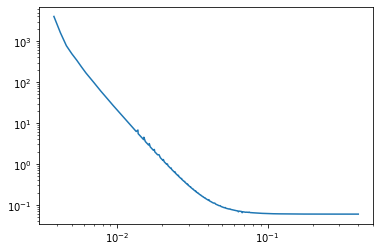

In [3]:
plt.plot(q, I)
plt.yscale('log')
plt.xscale('log')

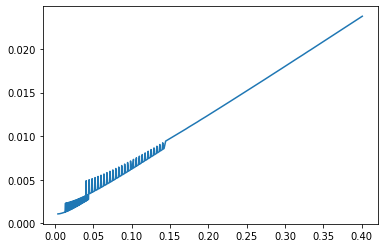

In [4]:
plt.plot(q, dq)

### Generating curves using `scipy stats` function

In [5]:
gauss_curves = []


In [6]:
x_axis = np.arange(-0.1, 0.1, 0.005)

In [7]:
x_axis + q[0]

array([-0.096203, -0.091203, -0.086203, -0.081203, -0.076203, -0.071203,
       -0.066203, -0.061203, -0.056203, -0.051203, -0.046203, -0.041203,
       -0.036203, -0.031203, -0.026203, -0.021203, -0.016203, -0.011203,
       -0.006203, -0.001203,  0.003797,  0.008797,  0.013797,  0.018797,
        0.023797,  0.028797,  0.033797,  0.038797,  0.043797,  0.048797,
        0.053797,  0.058797,  0.063797,  0.068797,  0.073797,  0.078797,
        0.083797,  0.088797,  0.093797,  0.098797])

In [8]:
len(x_axis)

40

In [9]:
step = 0.005
for index, sigma in enumerate(dq):
    x_axis = np.arange(-0.1, 0.1, 0.005)
    x_axis += q[index]
    gauss_curves.append(stats.norm.pdf(x_axis,q[index],sigma))
    

In [10]:
x_axis = np.arange(-0.1, 0.1, 0.005)
x_axis += q[-1]
x_axis

array([0.301, 0.306, 0.311, 0.316, 0.321, 0.326, 0.331, 0.336, 0.341,
       0.346, 0.351, 0.356, 0.361, 0.366, 0.371, 0.376, 0.381, 0.386,
       0.391, 0.396, 0.401, 0.406, 0.411, 0.416, 0.421, 0.426, 0.431,
       0.436, 0.441, 0.446, 0.451, 0.456, 0.461, 0.466, 0.471, 0.476,
       0.481, 0.486, 0.491, 0.496])

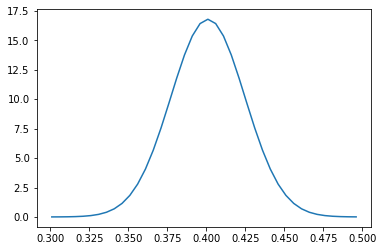

In [11]:
plt.plot(x_axis, gauss_curves[-1])

## TODO: Save to text file to generate 

Temporary format q, I(q), dI, dq, ResName, Npoints, [Dist data]

## Use generated curves in sasmodels 

In [12]:
from bumps.names import *
from sasmodels import direct_model
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from sasmodels.resolution import Resolution

import matplotlib.pyplot as plt

### Pinhole resolution

In [32]:
def apply_resolution_matrix(weight_matrix, theory):
    """
    Apply the resolution weight matrix to the computed theory function.
    """
    print("apply shapes", theory.shape, weight_matrix.shape)
    Iq = np.dot(theory[None, :], weight_matrix)
    print("result shape",Iq.shape)
    return Iq.flatten()

class Generic1D(Resolution):
    """
    Generic resolution function using weighted matrix input
    """
    def __init__(self, q, weight_matrix):
        self.q_calc = self.q = q
        
        #TODO: Eventually load this from file/data 
        self.weight_matrix = weight_matrix
        

    def apply(self, theory):
        return apply_resolution_matrix(self.weight_matrix, theory)

#Redifined here for testing purposes
PINHOLE_N_SIGMA = (2.5, 3.0)
MINIMUM_RESOLUTION = 1e-8
MINIMUM_ABSOLUTE_Q = 0.02

def bin_edges(x):
    """
    Determine bin edges from bin centers, assuming that edges are centered
    between the bins.

    Note: this uses the arithmetic mean, which may not be appropriate for
    log-scaled data.
    """
    if len(x) < 2 or (np.diff(x) < 0).any():
        raise ValueError("Expected bins to be an increasing set")
    edges = np.hstack([
        x[0]  - 0.5*(x[1]  - x[0]),  # first point minus half first interval
        0.5*(x[1:] + x[:-1]),        # mid points of all central intervals
        x[-1] + 0.5*(x[-1] - x[-2]), # last point plus half last interval
        ])
    return edges

def linear_extrapolation(q, q_min, q_max):
    """
    Extrapolate *q* out to [*q_min*, *q_max*] using the step size in *q* as
    a guide.  Extrapolation below uses about the same size as the first
    interval.  Extrapolation above uses about the same size as the final
    interval.

    Note that extrapolated values may be negative.
    """
    q = np.sort(q)
    if q_min + 2*MINIMUM_RESOLUTION < q[0]:
        n_low = int(np.ceil((q[0]-q_min) / (q[1]-q[0]))) if q[1] > q[0] else 15
        q_low = np.linspace(q_min, q[0], n_low+1)[:-1]
    else:
        q_low = []
    if q_max - 2*MINIMUM_RESOLUTION > q[-1]:
        n_high = int(np.ceil((q_max-q[-1]) / (q[-1]-q[-2]))) if q[-1] > q[-2] else 15
        q_high = np.linspace(q[-1], q_max, n_high+1)[1:]
    else:
        q_high = []
    return np.concatenate([q_low, q, q_high])


def pinhole_extend_q(q, q_width, nsigma=PINHOLE_N_SIGMA):
    """
    Given *q* and *q_width*, find a set of sampling points *q_calc* so
    that each point $I(q)$ has sufficient support from the underlying
    function.
    """
    try:
        nsigma_low, nsigma_high = nsigma
    except TypeError:
        nsigma_low = nsigma_high = nsigma
    q_min, q_max = np.min(q - nsigma_low*q_width), np.max(q + nsigma_high*q_width)
    return linear_extrapolation(q, q_min, q_max)

def pinhole_resolution(q_calc, q, q_width, nsigma=PINHOLE_N_SIGMA):
    r"""
    Compute the convolution matrix *W* for pinhole resolution 1-D data.

    Each row *W[i]* determines the normalized weight that the corresponding
    points *q_calc* contribute to the resolution smeared point *q[i]*.  Given
    *W*, the resolution smearing can be computed using *dot(W,q)*.

    Note that resolution is limited to $\pm 2.5 \sigma$.[1]  The true resolution
    function is a broadened triangle, and does not extend over the entire
    range $(-\infty, +\infty)$.  It is important to impose this limitation
    since some models fall so steeply that the weighted value in gaussian
    tails would otherwise dominate the integral.

    *q_calc* must be increasing.  *q_width* must be greater than zero.

    [1] Barker, J. G., and J. S. Pedersen. 1995. Instrumental Smearing Effects
    in Radially Symmetric Small-Angle Neutron Scattering by Numerical and
    Analytical Methods. Journal of Applied Crystallography 28 (2): 105--14.
    https://doi.org/10.1107/S0021889894010095.
    """
    # The current algorithm is a midpoint rectangle rule.  In the test case,
    # neither trapezoid nor Simpson's rule improved the accuracy.
    edges = bin_edges(q_calc)
    #edges[edges < 0.0] = 0.0 # clip edges below zero
    cdf = erf((edges[:, None] - q[None, :]) / (sqrt(2.0)*q_width)[None, :])
    weights = cdf[1:] - cdf[:-1]
    # Limit q range to (-2.5,+3) sigma
    try:
        nsigma_low, nsigma_high = nsigma
    except TypeError:
        nsigma_low = nsigma_high = nsigma
    qhigh = q + nsigma_high*q_width
    qlow = q - nsigma_low*q_width  # linear limits
    ##qlow = q*q/qhigh  # log limits
    weights[q_calc[:, None] < qlow[None, :]] = 0.
    weights[q_calc[:, None] > qhigh[None, :]] = 0.
    weights /= np.sum(weights, axis=0)[None, :]
    return weights

class Pinhole1D(Resolution):
    r"""
    Pinhole aperture with q-dependent gaussian resolution.

    *q* points at which the data is measured.

    *q_width* gaussian 1-sigma resolution at each data point.

    *q_calc* is the list of points to calculate, or None if this should
    be estimated from the *q* and *q_width*.

    *nsigma* is the width of the resolution function.  Should be 2.5.
    See :func:`pinhole_resolution` for details.
    """
    def __init__(self, q, q_width, q_calc=None, nsigma=PINHOLE_N_SIGMA):
        #*min_step* is the minimum point spacing to use when computing the
        #underlying model.  It should be on the order of
        #$\tfrac{1}{10}\tfrac{2\pi}{d_\text{max}}$ to make sure that fringes
        #are computed with sufficient density to avoid aliasing effects.

        # Protect against calls with q_width=0.  The extend_q function will
        # not extend the q if q_width is 0, but q_width must be non-zero when
        # constructing the weight matrix to avoid division by zero errors.
        # In practice this should never be needed, since resolution should
        # default to Perfect1D if the pinhole geometry is not defined.
        self.q, self.q_width = q, q_width
        self.q_calc = (pinhole_extend_q(q, q_width, nsigma=nsigma)
                       if q_calc is None else np.sort(q_calc))

        # Protect against models which are not defined for very low q.  Limit
        # the smallest q value evaluated (in absolute) to 0.02*min
        cutoff = MINIMUM_ABSOLUTE_Q*np.min(self.q)
        self.q_calc = self.q_calc[abs(self.q_calc) >= cutoff]

        # Build weight matrix from calculated q values
        self.weight_matrix = pinhole_resolution(
            self.q_calc, self.q, np.maximum(q_width, MINIMUM_RESOLUTION),
            nsigma=nsigma)

        # Force positive q, even for events measured on the opposite side of
        # the beam stop.
        self.q_calc = abs(self.q_calc)

    def apply(self, theory):
        return apply_resolution_matrix(self.weight_matrix, theory)


In [33]:
pinhole_resolution = Pinhole1D(q, dq)

pars = dict(scale=1, background=0.65, sld=1, sld_solvent=6) 
model = load_model('sphere')
#model_setup = load_model('sphere')
#resolutuion.q_calc is the same (at least in this case)
kernel = model.make_kernel([pinhole_resolution.q_calc])
theory = direct_model.call_kernel(kernel, pars)
Iq_pinhole = pinhole_resolution.apply(theory)

kernel.release()

apply shapes (330,) (330, 301)
result shape (1, 301)


In [ ]:
generic_resolution = Generic1D(q, np.array(gauss_curves))

In [ ]:
pars = dict(scale=1, background=0.65, sld=1, sld_solvent=6) 
model = load_model('sphere')
#model_setup = load_model('sphere')
#resolutuion.q_calc is the same (at least in this case)
kernel = model.make_kernel([generic_resolution.q_calc])
theory = direct_model.call_kernel(kernel, pars)
Iq_generic = generic_resolution.apply(theory)

In [ ]:
plt.loglog(pinhole_resolution.q, theory, label='unsmeared')
plt.loglog(pinhole_resolution.q, Iq_pinhole, label='pinhole_smeared')
#plt.loglog(generic_resolution.q, Iq_generic, label='generic_smeared')

plt.legend()
plt.xlabel("Q (1/Ang)")
plt.ylabel("I(Q) (1/cm)")